In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('figure', facecolor='w')
import astropy.io.fits as fits
from astropy.io import ascii
import math, os
import itertools

#optional dependencies
from distutils.spawn import find_executable
if find_executable('latex'): rc('text', usetex=True)
else: rc('text', usetex=False)
    
from bsub import bsub

In [23]:
def reduce(dataf, flatf):
    """
    Bias-subtract and normalize science images.
    """  
    flat = fits.getdata(flatf)
    dat = fits.getdata(dataf)
    hdr = fits.getheader(dataf)

    #Bias subtract
    datab = bsub(dat, hdr.get('cover')) 
    flatb = bsub(flat, hdr.get('cover')) 
    
    #Normalize
    flatb = flatb/np.median(flatb)
    reduced = datab/flatb
    
    return reduced

def plotImg(arr, **kwargs):
    """
    Plot 2D science image with identified objects.
    """
    avg = np.mean(arr.flatten())
    std = np.std(arr.flatten())
    dim = arr.shape
    rng = kwargs.get('rng', [np.percentile(arr, 5), np.percentile(arr, 95)])
    
    fig, ax = plt.subplots(1)
    pl = plt.imshow(arr, origin='lower', interpolation='nearest', cmap='gray_r', \
                    vmin=rng[0], vmax=rng[1])
    
    if 'pts' in kwargs:
        pts = kwargs.get('pts')
        plt.scatter(pts[0], pts[1], marker='o', s=50, facecolors='none', edgecolors='r')

    plt.colorbar(pl).set_label('Detector Value (ADU)')
    plt.xlabel('pixels(x)')
    plt.ylabel('pixels(y)')
    plt.xlim(0, dim[0])
    plt.ylim(0, dim[1])
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()

In [21]:
def findStar(red, **kwargs):
    """
    Find all points in a 2D image with ADU counts above a percentile threshold.
    """
    percentile = kwargs.get('percentile', 99)
    cut = np.percentile(red.flatten(), percentile)
    
    pts = []
    for row in range(red.shape[0]):
        idx = np.where(red[row] >= cut)[0]
        if len(idx) != 0:
            for col in idx:
                pts.append([row, col])
    pts = np.array(pts)
    
    return pts

def dist(r1, r2):
    """
    Return Euclidean distance between two 2D vectors.
    """
    return np.sqrt((r1[0]-r2[0])**2 + (r1[1]-r2[1])**2)

In [72]:
def removePixels(pts, **kwargs):
    """
    Remove points associated with bad rows or columns of the detector.
    """
    rows = kwargs.get('rows', [])
    cols = kwargs.get('cols', [])
    
    xpts, ypts = [], []
    for p in star_pts:
        if p[1] not in cols:
            xpts.append(p[0])
            ypts.append(p[1])
    pts = np.array([ypts, xpts])
    
    return pts.T

def clusterPoints(ptlist, **kwargs):
    """
    Cluster points into separate arrays if they are within the distance
    of a specified radius.
    """
    radius = kwargs.get('radius', 10)
    
    clusters = []
    clus = []
    cpt = ptlist[0]
    for i in range(len(ptlist)):
        if dist(cpt, ptlist[i]) < radius**2:
            clus.append(ptlist[i])
        else:
            cpt = ptlist[i+1]
            clusters.append(np.array(clus))
            clus = []
            
    return np.array(clusters)

def findClusterMax(red, clusters):
    
    peaks = []
    for clus in clusters:
        adu_vals = []
        for pt in clus:
            adu_vals.append(red[pt[0], pt[1]])
        max_adu_idx = np.where(adu_vals == max(adu_vals))[0][0]
        peaks.append(clus[max_adu_idx])
        
    return np.array(peaks)

def centroid(red, clusters, **kwargs):
    
    radius = kwargs.get('radius', 20)
    
    return none

In [154]:
points = ptlist

clusters = []
while len(points) > 0:
    p0 = points[0]
    clus = []
    new_list = []
    for pt in points:
        if dist(p0, pt) < 5**2:
            clus.append(pt)
        else:
            new_list.append(pt)
    clusters.append(np.array(clus))
    points = new_list

In [155]:
np.array(clusters)

array([array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       [ 3,  0],
       [ 5,  0],
       [ 6,  0],
       [ 8,  0],
       [ 9,  0],
       [10,  0],
       [11,  0],
       [13,  0],
       [15,  0],
       [17,  0],
       [ 1,  1],
       [ 3,  1],
       [ 5,  1],
       [ 7,  1],
       [ 8,  1],
       [ 1,  2],
       [ 3,  2],
       [ 4,  2],
       [ 5,  2],
       [ 6,  2],
       [ 9,  2],
       [ 2,  3],
       [ 3,  3],
       [ 6,  3],
       [ 7,  3],
       [ 8,  3],
       [ 9,  3],
       [ 1,  4],
       [ 2,  4],
       [ 3,  4],
       [ 7,  4],
       [ 1,  5],
       [ 2,  5],
       [ 3,  5],
       [ 4,  5],
       [ 8,  5],
       [ 2,  6],
       [ 3,  6],
       [ 4,  6],
       [ 5,  6],
       [ 7,  6],
       [ 1,  7],
       [ 2,  7],
       [ 3,  7],
       [ 1,  8],
       [ 2,  8],
       [ 3,  8],
       [ 4,  8],
       [ 1,  9],
       [ 2,  9],
       [ 4,  9],
       [ 5,  9],
       [ 1, 10],
       [ 2, 10],
       [ 1, 11],
       

In [ ]:
red = reduce('data/demo/d159.fits', 'data/demo/d121.fits')

57 57


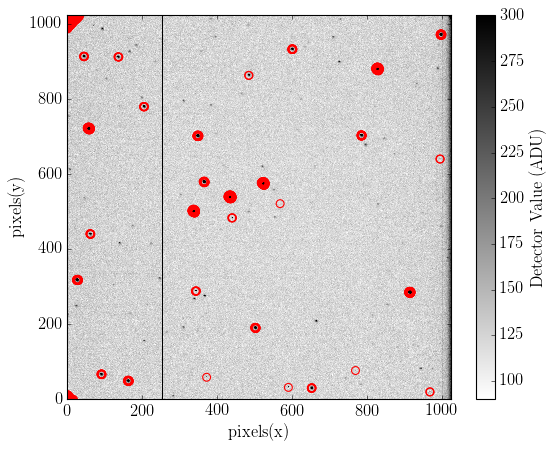

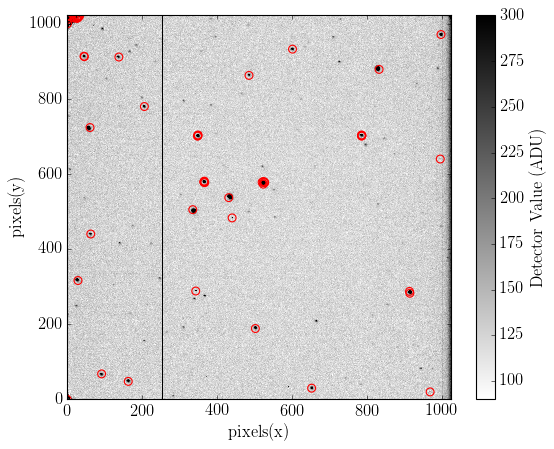

In [134]:
star_pts = findStar(red, percentile=99.6)

bad_col = [255, 256] + list(np.arange(1000,1025))
ptlist = removePixels(star_pts, cols=bad_col)

clusters1 = clusterPoints(ptlist, radius=5)
peaks1 = findClusterMax(red, clusters1)
print(len(clusters1), len(peaks1))

# clusters2 = clusterPoints(peaks1, radius=5)
# peaks2 = findClusterMax(red, clusters2)

# len(peaks1), len(peaks2)

plotImg(red, pts=ptlist.T, rng=[90,300])
plotImg(red, pts=peaks1.T, rng=[90,300])
# plotImg(red, pts=peaks2.T, rng=[90,300])

In [138]:
ptlist[0:20]

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       [ 3,  0],
       [ 5,  0],
       [ 6,  0],
       [ 8,  0],
       [ 9,  0],
       [10,  0],
       [11,  0],
       [13,  0],
       [15,  0],
       [17,  0],
       [ 1,  1],
       [ 3,  1],
       [ 5,  1],
       [ 7,  1],
       [ 8,  1],
       [ 1,  2],
       [ 3,  2]])

In [136]:
peaks1

array([[   0,    0],
       [ 968,   20],
       [ 652,   30],
       [ 163,   48],
       [  92,   68],
       [ 502,  189],
       [ 914,  283],
       [ 913,  288],
       [ 343,  289],
       [  29,  317],
       [  63,  441],
       [ 440,  484],
       [ 335,  506],
       [ 431,  538],
       [ 523,  574],
       [ 367,  578],
       [ 527,  578],
       [ 365,  579],
       [ 520,  579],
       [ 365,  580],
       [ 526,  580],
       [ 365,  581],
       [ 523,  581],
       [ 366,  582],
       [ 995,  641],
       [ 348,  702],
       [ 785,  702],
       [ 348,  703],
       [ 786,  703],
       [ 349,  704],
       [ 786,  704],
       [ 349,  705],
       [ 785,  705],
       [  61,  725],
       [ 206,  781],
       [ 485,  864],
       [ 832,  880],
       [ 138,  913],
       [  46,  914],
       [  45,  915],
       [ 601,  934],
       [ 997,  973],
       [   1, 1002],
       [   0, 1013],
       [  26, 1016],
       [  18, 1017],
       [  28, 1017],
       [  21,